In [1]:
%matplotlib inline
import numpy as np
import time
import pandas as pd
import ipywidgets as widgets
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from feedback_spgd import SPGD
from feedback_nn import CombineNN

mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = "both"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['grid.alpha'] = 0.5
mpl.rcParams["legend.loc"] = 'upper right'

%precision 1
np.set_printoptions(suppress=True, linewidth=150)

In [2]:
def feedback(system, n_steps=50, start_perturb_deg=180):
    system.model.reset()
    system.model.perturb_random(start_perturb_deg)
    etas = []
    diag = []  # holds information per iteration
    for i in tqdm(range(n_steps)):
        etas.append(system.model.norm_eta)
        system.iterate()
        diag.append(system.diagnose())
    return etas, diag

def plot_feedback(df, title=''):
    fig, ax = plt.subplots()
    df.plot(ax=ax, lw=1, legend=False, ylim=(0,105))
    ax.set_xlabel('Number of steps')
    ax.set_ylabel('Normalized efficiency [%]')
    ax.set_title(title + '# runs:{}'.format(df.shape[-1]))
    return fig;

def sim_feedback(system, n_runs=2, n_steps=50, start_perturb_deg=180):
    etas_arr = []
    diag_arr = []
    for j in range(n_runs):
        eta, diag = feedback(system, n_steps=n_steps, start_perturb_deg=start_perturb_deg)
        etas_arr.append(eta)
        diag_arr.append(diag)
    return np.asarray(etas_arr).T * 100, np.asarray(diag_arr)

# Free running 3x3 setup

with environmental phase drifting and measurement noise

In [4]:
phs_drift_step_deg = 2
rms_measure_noise = 0.1
free_running_config = {
    'M': 3,
    'gain': 0,
    'rms_measure_noise': rms_measure_noise,
    'phs_drift_step_deg': phs_drift_step_deg,
}
zero_gain = SPGD(**free_running_config)
eta_free, diag_free = sim_feedback(zero_gain, n_steps=500, n_runs=4, start_perturb_deg=0)
df_free = pd.DataFrame(eta_free)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1269.19it/s]


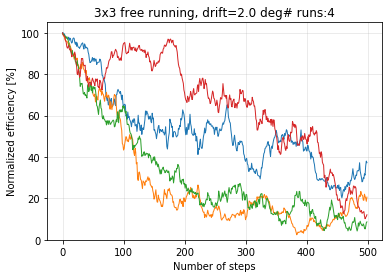

In [5]:
plot_feedback(df_free, title=f'3x3 free running, drift={phs_drift_step_deg:.1f} deg');

# SPGD based feedback

From [M.Vorontsov, Optics letters 22.12 (1997): 907-909](https://doi.org/10.1364/OL.22.000907):
$$
  u_j^{(n+1)} = u_j^{(n)} + \gamma \delta J^{(n)}\delta u_j^{(n)}, \qquad j \in [0,81)
$$

where $\delta u_j$ are statistically independent random perturbations with equal amplitude,
$J$ is cost function as a function of control outputs $u_j$.

The steps:
1. Generate $\delta u_j$;
2. Apply control voltage with positive perturbations and evaluate cost function:
    $$
    J_+ = J(u_1 + \delta u_1, u_2 + \delta u_2, \cdots)
    $$
3. Apply control voltage with positive perturbations and evaluate cost function:
    $$
    J_- = J(u_1 - \delta u_1, u_2 - \delta u_2, \cdots)
    $$
4. Calculate difference:
    $$
    \delta J = J_+ - J_-
    $$
5. Update control voltage:
    $$
    u_j^{(n+1)} = u_j^{(n)} + \gamma \delta u_j \delta J, \qquad j \in [0,81)
    $$
    
where $\gamma$ is the update gain.

In [6]:
config = {
    'M': 3,
    'gain': 1,
    'dither_rms_deg': 40,
    'ortho_sampling': False,
    'rms_measure_noise': rms_measure_noise,
    'phs_drift_step_deg': phs_drift_step_deg,
}
spgd = SPGD(**config)

In [7]:
eta_spgd, diag_spgd = sim_feedback(spgd, n_steps=500, n_runs=4, start_perturb_deg=180)
df_spgd = pd.DataFrame(eta_spgd)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1440.63it/s]


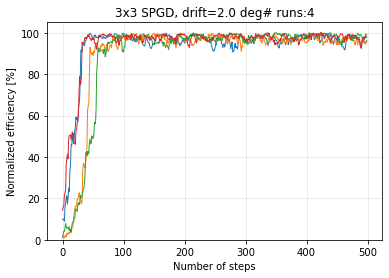

In [8]:
plot_feedback(df_spgd, title=f'3x3 SPGD, drift={phs_drift_step_deg:.1f} deg');

# NN pattern recognition based feedback

in the same environment

In [3]:
phs_drift_step_deg = 2
rms_measure_noise = 0.1
# phs_drift_step_deg = 1
test_config = {
    'M':        3,
    'gain':     1,
    'rms_measure_noise': rms_measure_noise,
    'phs_drift_step_deg': phs_drift_step_deg,
    'double_frame': True,
    'nn_weight': 'nn_trained/3by3_45deg.pth',
    'nn_config': 'nn_trained/3by3_45deg.json'
}
nn = CombineNN(**test_config)

Sequential(
  (0): Linear(in_features=50, out_features=60, bias=True)
  (1): ReLU()
  (2): Linear(in_features=60, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=15, bias=True)
  (5): ReLU()
  (6): Linear(in_features=15, out_features=8, bias=True)
)


In [6]:
eta_nn, diag_nn = sim_feedback(nn, n_runs=8, n_steps=200, start_perturb_deg=180)
df_nn = pd.DataFrame(eta_nn)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1165.63it/s]


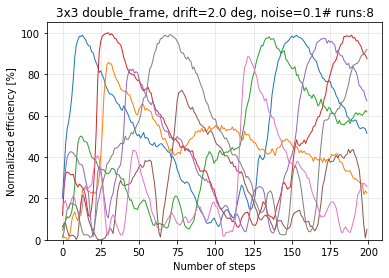

In [7]:
plot_feedback(
    df_nn,
    title=f'3x3 double_frame, drift={phs_drift_step_deg:.1f} deg, noise={rms_measure_noise:.1f}'
);